In [5]:
from osgeo import gdal
import os
import geopandas as gpd

In [7]:
from sklearn.cluster import KMeans

In [6]:
dir = "E:\\greenland_Campus\\GisDataforChina\\"
gdf = gpd.read_file(dir+'AOI_gpkg\\aoi_geoT21.gpkg')

In [8]:
gdf.columns

Index(['num', '序号', '学校名', '学校标', '主管部', '所在地', '办学层', '备注', 'campusName',
       'uid', 'area', '面积', 'lngC', 'latC', '面积Albers', 'aspect_ratio',
       'orient', 'building_area', 'density_BD', 'NN_avr', 'NN_std', 'NNI',
       'geometry'],
      dtype='object')

In [9]:
data = gdf[['lngC', 'latC']].values
data

array([[109.53016948,  18.31208116],
       [109.55582748,  18.33582758],
       [110.33302417,  19.92258451],
       ...,
       [120.0714697 ,  30.30396342],
       [121.42448176,  31.02513249],
       [115.78850132,  28.64782475]])

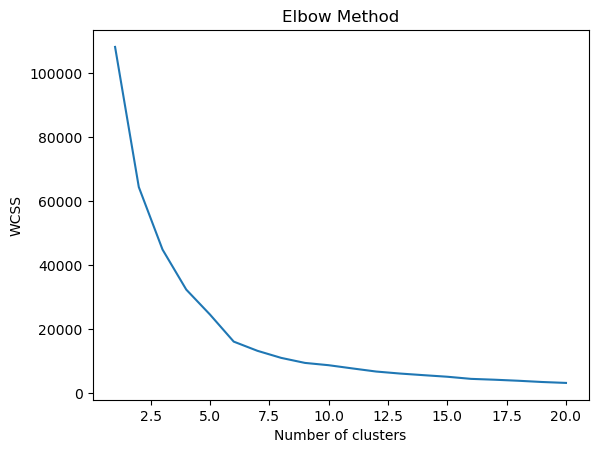

In [12]:
wcss = []
for i in range(1, 21):  # 测试1到10个聚类
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# 绘制肘部曲线
import matplotlib.pyplot as plt

plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [17]:
# 选择聚类的数量
k = 10  # 假设我们想要分成3个聚类

# 创建KMeans实例
kmeans = KMeans(n_clusters=k, random_state=0)

# 执行KMeans聚类
kmeans.fit(data)

# 预测聚类标签
labels = kmeans.labels_

# 将聚类标签添加到原始数据中
gdf['cluster'] = labels

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [15]:
import seaborn as sns

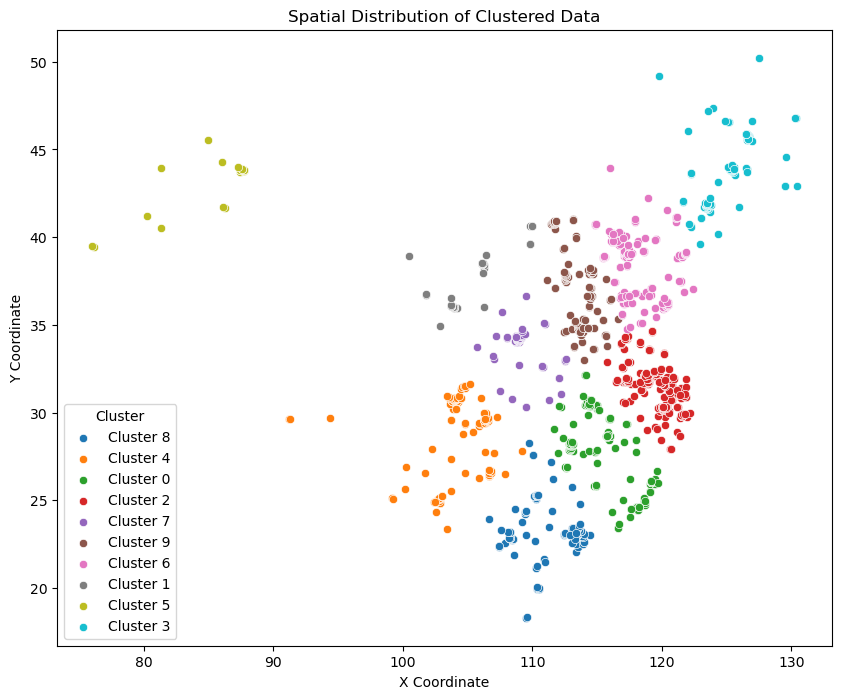

In [18]:
# 创建一个matplotlib图表对象
plt.figure(figsize=(10, 8))

# 使用不同的颜色绘制每个聚类
for cluster in gdf['cluster'].unique():
    cluster_data = gdf[gdf['cluster'] == cluster]
    sns.scatterplot(x='lngC', y='latC', data=cluster_data, label=f'Cluster {cluster}')

# 添加图例
plt.legend(title='Cluster')

# 添加标题和轴标签
plt.title('Spatial Distribution of Clustered Data')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# 显示图表
plt.show()

In [19]:
gdf.to_file(dir+'AOI_gpkg\\aoi_geo_clustered.gpkg', driver='GPKG')

In [35]:
# 定义输入栅格文件列表和输出文件路径
input_files = ['H:/layers/img_compressed/campus_{}.tif'.format(i) for i in range(0, 4)]
output_file = 'merged_raster1.tif'

# 使用GDAL的Merge函数合并栅格文件
dataset_list = [gdal.Open(x) for x in input_files]
# driver = gdal.GetDriverByName('GTiff')
# output_dataset = driver.CreateCopy(output_file, dataset_list[0], 0)

In [32]:
def Mosaic_GDAL(dataset_list, path_out):

    input_proj = dataset_list[0].GetProjection()

    # 输入投影，输出投影，输出格式，重采样方法
    options = gdal.WarpOptions(srcSRS=input_proj, dstSRS=input_proj, format='GTiff',
                               resampleAlg=gdal.GRA_NearestNeighbour,options=['TILED=YES', 'COMPRESS=LZW'])
    
    # 输出路径，需要镶嵌的数据，参数配置
    gdal.Warp(path_out, dataset_list, options=options)
    
    ds = gdal.Open(path_out, gdal.GA_ReadOnly)
    ds.BuildOverviews(overviewlist=[2, 4, 8, 16])
    # 创建金字塔
    del dataset_list, ds

In [37]:
Mosaic_GDAL(dataset_list ,output_file)